In [13]:
import pandas as pd

# Read in the edgelist file from csv
file_network = pd.read_csv("london_flows.csv")

# Print data (first five rows)
file_network.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [4]:
import numpy as np
from scipy.optimize import curve_fit

# 定义模型函数
def model_function(cij, K, Oi, Dj, b):
    return K * Oi * Dj * np.exp(-b * cij)

# 提取出 origin, destination, population, jobs, flow, distance 数据
origin = file_network['station_origin']
destination = file_network['station_destination']
population = file_network['population']
jobs = file_network['jobs']
flow = file_network['flows']
distance = file_network['distance']

# 定义初始猜测值
initial_guess = [1.0, 1.0, 1.0, 1.0]  # 初始猜测值，可以根据实际情况调整

# 进行最小二乘拟合
parameters, covariance = curve_fit(model_function, distance, flow, p0=initial_guess)

# 提取出成本函数参数 b
b = parameters[-1]

print("Estimated value of b:", b)



Estimated value of b: 0.9996813991480555


In [15]:
import numpy as np
import pandas as pd

# 假设原始数据存储在一个名为 file_network 的数据集中，包含 origin, destination, population, jobs, flows 列
# 假设 flows 列包含通勤者流量数据，jobs 列包含工作数量数据

# 计算原始通勤者数量
original_commute = np.sum(file_network['flows'])

# 更新 Canary Wharf 的工作数量
canary_wharf_index = np.where(file_network['station_origin'] == 'Canary Wharf')[0][0]
file_network['jobs'][canary_wharf_index] *= 0.5  # 减少50%

# 计算重新分配的通勤者数量
new_jobs = file_network['jobs']
new_flow = np.zeros_like(file_network['flows'])

# 重新分配通勤流量
for i, row in enumerate(file_network):
    if i == canary_wharf_index:  # 跳过 Canary Wharf 行
        continue
    
    # 计算从第 i 行到 Canary Wharf 的通勤者数量
    commute_to_canary_wharf = file_network['flows'][i] * file_network['jobs'][canary_wharf_index] / np.sum(file_network['jobs'])
    
    # 计算从 Canary Wharf 到第 i 行的通勤者数量
    commute_from_canary_wharf = file_network['flows'][i] * file_network['jobs'][i] / np.sum(file_network['jobs'])
    
    # 计算新的通勤者数量
    new_flow[i] = file_network['flows'][i] * (1 - 0.5) + commute_to_canary_wharf
    new_flow[canary_wharf_index] += commute_from_canary_wharf  # 更新金丝雀码头的通勤流量

# 验证总通勤者数量是否与原始数量相同
if np.isclose(np.sum(new_flow), original_commute):
    print("通勤者数量保持不变")
else:
    print("通勤者数量未能保持不变")

# 将新的通勤流量保存到表格
new_data = pd.DataFrame({'origin': file_network['station_origin'],
                         'destination': file_network['station_destination'],
                         'population': file_network['population'],
                         'jobs': new_jobs,
                         'flows': new_flow})

# 保存到 CSV 文件
new_data.to_csv('new_commute_data.csv', index=False)

print("新的通勤流量已保存到 new_commute_data.csv")


/tmp/ipykernel_120/3944620521.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_network['jobs'][canary_wharf_index] *= 0.5  # 减少50%


通勤者数量未能保持不变
新的通勤流量已保存到 new_commute_data.csv


In [23]:
import networkx as nx
import pandas as pd

# 创建一个带有权重的图
g_station_weighted = nx.Graph()

# 遍历数据，并添加带有权重的边
for _, row in file_network.iterrows():
    station_origin = row['station_origin']
    station_destination = row['station_destination']
    population = row['population']
    g_station_weighted.add_edge(station_origin, station_destination, weight=population)

# 计算加权后的特征向量中心性
weighted_eigenvector_centrality = nx.eigenvector_centrality(g_station_weighted, weight='weight')

# 将结果排序并存储在 DataFrame 中
sorted_nodes = sorted(weighted_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'weighted_eigenvector_centrality'])

# 打印排名前十的节点及其加权后的特征向量中心性
top_10 = df.head(10)
print(top_10)


                      nodes  weighted_eigenvector_centrality
0                  Waterloo                         0.385366
1                 Stratford                         0.332440
2                  Victoria                         0.218418
3             London Bridge                         0.144524
4          Liverpool Street                         0.144128
5                Paddington                         0.124581
6  King's Cross St. Pancras                         0.124316
7             Seven Sisters                         0.110473
8      Highbury & Islington                         0.106879
9                  Vauxhall                         0.103369


In [28]:
import networkx as nx
import pandas as pd

# 创建一个带有权重的图
g_station_weighted = nx.Graph()

# 遍历数据，并添加带有权重的边
for _, row in file_network.iterrows():
    station_origin = row['station_origin']
    station_destination = row['station_destination']
    population = row['population']
    g_station_weighted.add_edge(station_origin, station_destination, weight=population)

# 计算加权后的特征向量中心性
weighted_closeness_centrality = nx.closeness_centrality(g_station_weighted, distance='weight')

# 将结果排序并存储在 DataFrame 中
sorted_nodes = sorted(weighted_closeness_centrality.items(), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'weighted_closeness_centrality'])

# 打印排名前十的节点及其加权后的特征向量中心性
top_10 = df.head(10)
print(top_10)


               nodes  weighted_closeness_centrality
0             Temple                       0.001609
1   Hyde Park Corner                       0.001479
2         Kensington                       0.001434
3      Regent's Park                       0.001398
4            Barking                       0.001337
5       Canning Town                       0.001336
6  Bank and Monument                       0.001336
7       Canary Wharf                       0.001335
8      Goodge Street                       0.001322
9      Bethnal Green                       0.001302


In [30]:
import networkx as nx
import pandas as pd

# 创建一个带有权重的图
g_station_weighted = nx.Graph()

# 遍历数据，并添加带有权重的边
for _, row in file_network.iterrows():
    station_origin = row['station_origin']
    station_destination = row['station_destination']
    population = row['population']
    g_station_weighted.add_edge(station_origin, station_destination, weight=population)

# 计算边介数中心性
weighted_edge_betweenness_centrality = nx.edge_betweenness_centrality(g_station_weighted, weight='weight')

# 根据边介数中心性计算节点介数中心性
weighted_betweenness_centrality = nx.betweenness_centrality(g_station_weighted, weight='weight')

# 将结果排序并存储在 DataFrame 中
sorted_nodes = sorted(weighted_betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'weighted_betweenness_centrality'])

# 打印排名前十的节点及其加权后的介数中心性
top_10 = df.head(10)
print(top_10)


               nodes  weighted_betweenness_centrality
0             Temple                         0.415507
1   Hyde Park Corner                         0.229258
2         Kensington                         0.197597
3    West India Quay                         0.163404
4   Liverpool Street                         0.060542
5          Shenfield                         0.053813
6  Bank and Monument                         0.048245
7          Stratford                         0.044561
8       Canning Town                         0.043849
9     Upper Holloway                         0.042272


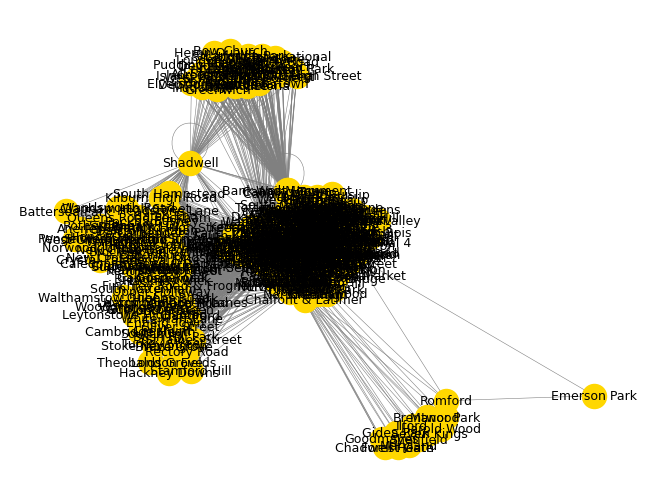

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph object
g_station = nx.from_pandas_edgelist(file_network, 'station_origin', 'station_destination','population')

# Plot graph
nx.draw(g_station,
        with_labels = True,
        node_color='gold',
        font_size=9,
        font_color='black',
        edge_color='gray',
        width=0.4)

In [3]:
import networkx as nx
import pandas as pd


eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)


                  nodes  eigenvector_centrality
0             Stratford                0.073653
1          Canada Water                0.073103
2      Liverpool Street                0.073062
3          Canary Wharf                0.072862
4           Whitechapel                0.072779
5     Bank and Monument                0.072534
6         London Bridge                0.072491
7              Victoria                0.072491
8  Highbury & Islington                0.072480
9          Canning Town                0.072396


In [4]:
import networkx as nx
import pandas as pd

# 假设您已经有一个名为 'G' 的 NetworkX 图
# 请将 'G' 替换为您的图的名称

# 计算特征向量中心性
closeness_centrality = nx.closeness_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'closeness_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)


                  nodes  closeness_centrality
0             Stratford              0.927739
1  Highbury & Islington              0.836134
2           Whitechapel              0.820619
3         West Brompton              0.817248
4          Canada Water              0.813906
5     Bank and Monument              0.810591
6          Canary Wharf              0.810591
7              Richmond              0.810591
8          Canning Town              0.808943
9      Liverpool Street              0.808943


In [5]:
import networkx as nx
import pandas as pd

# 假设您已经有一个名为 'G' 的 NetworkX 图
# 请将 'G' 替换为您的图的名称

# 计算特征向量中心性
betweenness_centrality = nx.betweenness_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'betweenness_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)


                  nodes  betweenness_centrality
0             Stratford                0.098553
1      Liverpool Street                0.034307
2     Bank and Monument                0.027956
3          Canary Wharf                0.027956
4          Canning Town                0.027757
5              West Ham                0.024551
6  Highbury & Islington                0.023023
7           Whitechapel                0.019682
8          Canada Water                0.017898
9              Shadwell                0.017070


In [21]:
import networkx as nx

G= g_station_weighted

# 计算节点1的加权聚类系数
def weighted_clustering_coefficient(g_station_weighted, node):
    neighbors = list(g_station_weighted.neighbors(node))
    weighted_edges = []
    for i in range(len(neighbors)):
        for j in range(i+1, len(neighbors)):
            neighbor_i = neighbors[i]
            neighbor_j = neighbors[j]
            if G.has_edge(neighbor_i, neighbor_j):
                edge_weight = G[neighbor_i][neighbor_j]['weight']
                weighted_edges.append(edge_weight)
    if len(weighted_edges) < 2:
        return 0
    numerator = 2 * sum(weighted_edges)
    denominator = len(weighted_edges) * (len(weighted_edges) - 1)
    return numerator / denominator


# 计算节点1的加权聚类系数
node = 'Stratford'
print("节点 {} 的加权聚类系数为: {}".format(node, weighted_clustering_coefficient(G, node)))

# 删除节点1
g_station_weighted.remove_node(node)

# 计算删除节点1后的加权聚类系数
print("删除节点 {} 后的加权聚类系数为: {}".format(node, nx.average_clustering(G, weight='weight')))

# 计算节点1的加权聚类系数
node = 'Victoria'
print("节点 {} 的加权聚类系数为: {}".format(node, weighted_clustering_coefficient(G, node)))

# 删除节点1
g_station_weighted.remove_node(node)

# 计算删除节点1后的加权聚类系数
print("删除节点 {} 后的加权聚类系数为: {}".format(node, nx.average_clustering(G, weight='weight')))


节点 Stratford 的加权聚类系数为: 0.3211207295909963
删除节点 Stratford 后的加权聚类系数为: 0.07593104431412886
节点 Victoria 的加权聚类系数为: 0.3575492855921996
删除节点 Victoria 后的加权聚类系数为: 0.0843986262767244


In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create the graph
g_station = nx.from_pandas_edgelist(file_network, 'station_origin', 'station_destination', 'flows')

# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Waterloo')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.3994660016876362
density after deletion: 0.3981241218687898


In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create the graph
g_station = nx.from_pandas_edgelist(file_network, 'station_origin', 'station_destination', 'flows')

# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Stratford')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.3994660016876362


TypeError: Graph.remove_node() takes 2 positional arguments but 3 were given

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create the graph
g_station = nx.from_pandas_edgelist(file_network, 'station_origin', 'station_destination', 'flows')

# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Victoria')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.3994660016876362
density after deletion: 0.39811146412161563


In [4]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Stratford')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.6136855562446997
Average Shortest Path Length after deletion: 1.6415031931404727


In [5]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Victoria')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.6415031931404727
Average Shortest Path Length after deletion: 1.6430507607722797


In [32]:

# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                  nodes  eigenvector_centrality
0          Canada Water                0.073328
1      Liverpool Street                0.073265
2          Canary Wharf                0.073052
3           Whitechapel                0.072992
4         London Bridge                0.072748
5              Victoria                0.072748
6     Bank and Monument                0.072721
7  Highbury & Islington                0.072671
8            Paddington                0.072652
9          Canning Town                0.072583


In [33]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Canada Water')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.6399756971254256
Average Shortest Path Length after deletion: 1.6420756685240312


In [34]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                  nodes  eigenvector_centrality
0      Liverpool Street                0.073508
1          Canary Wharf                0.073303
2           Whitechapel                0.073176
3         London Bridge                0.072997
4              Victoria                0.072997
5     Bank and Monument                0.072970
6            Paddington                0.072901
7  Highbury & Islington                0.072853
8          Canning Town                0.072831
9              Waterloo                0.072767


In [35]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Liverpool Street')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.6420756685240312
Average Shortest Path Length after deletion: 1.7153688786600179


In [36]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                  nodes  eigenvector_centrality
0          Canary Wharf                0.073555
1           Whitechapel                0.073412
2         London Bridge                0.073243
3              Victoria                0.073243
4     Bank and Monument                0.073218
5            Paddington                0.073148
6          Canning Town                0.073079
7  Highbury & Islington                0.073079
8              Waterloo                0.073012
9            Old Street                0.072908


In [38]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Canary Wharf')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.7153688786600179
Average Shortest Path Length after deletion: 1.7176636895200155


In [39]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                  nodes  eigenvector_centrality
0           Whitechapel                0.073666
1         London Bridge                0.073489
2              Victoria                0.073489
3            Paddington                0.073394
4     Bank and Monument                0.073390
5  Highbury & Islington                0.073331
6              Waterloo                0.073256
7          Canning Town                0.073251
8           Bond Street                0.073151
9            Embankment                0.073151


In [40]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Whitechapel')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.7176636895200155
Average Shortest Path Length after deletion: 1.7239121168675167


In [41]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                  nodes  eigenvector_centrality
0         London Bridge                0.073745
1              Victoria                0.073745
2            Paddington                0.073649
3     Bank and Monument                0.073644
4              Waterloo                0.073510
5          Canning Town                0.073503
6  Highbury & Islington                0.073502
7  Tottenham Court Road                0.073403
8         Warren Street                0.073403
9           Westminster                0.073403


In [42]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('London Bridge')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.7239121168675167
Average Shortest Path Length after deletion: 1.72572311367295


In [43]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                    nodes  eigenvector_centrality
0                Victoria                0.073991
1              Paddington                0.073896
2       Bank and Monument                0.073891
3    Highbury & Islington                0.073756
4                Waterloo                0.073755
5            Canning Town                0.073750
6             Bond Street                0.073647
7              Embankment                0.073647
8              Green Park                0.073647
9  High Street Kensington                0.073647


In [44]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Victoria')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.72572311367295
Average Shortest Path Length after deletion: 1.7275431911895194


In [45]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                    nodes  eigenvector_centrality
0              Paddington                0.074145
1       Bank and Monument                0.074141
2    Highbury & Islington                0.074013
3                Waterloo                0.074002
4            Canning Town                0.073999
5             Bond Street                0.073893
6              Embankment                0.073893
7              Green Park                0.073893
8  High Street Kensington                0.073893
9                 Holborn                0.073893


In [46]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Paddington')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.7275431911895194
Average Shortest Path Length after deletion: 1.7293593022493279


In [47]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                      nodes  eigenvector_centrality
0         Bank and Monument                0.074394
1      Highbury & Islington                0.074272
2                  Waterloo                0.074253
3              Canning Town                0.074252
4               Bond Street                0.074142
5                Embankment                0.074142
6                Green Park                0.074142
7    High Street Kensington                0.074142
8                   Holborn                0.074142
9  King's Cross St. Pancras                0.074142


In [48]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Bank and Monument')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.7293593022493279
Average Shortest Path Length after deletion: 1.7322523235119636


In [49]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g_station)

# 按特征向量中心性对节点进行排序
sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 创建一个 DataFrame 来显示结果
df = pd.DataFrame(sorted_nodes, columns=['nodes', 'eigenvector_centrality'])

# 显示前 10 名节点
top_10 = df.head(10)
print(top_10)

                      nodes  eigenvector_centrality
0      Highbury & Islington                0.074535
1                  Waterloo                0.074508
2              Canning Town                0.074428
3               Bond Street                0.074395
4                Embankment                0.074395
5                Green Park                0.074395
6    High Street Kensington                0.074395
7                   Holborn                0.074395
8  King's Cross St. Pancras                0.074395
9                Old Street                0.074395


In [50]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Highbury & Islington')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)


Average Shortest Path Length before deletion: 1.7322523235119636
Average Shortest Path Length after deletion: 1.7427848302546842


# 分界线

In [56]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Liverpool Street')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.6122970743441518
Average Shortest Path Length after deletion: 1.6148120957431997


In [8]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Bank and Monument')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.7130371727349056
Average Shortest Path Length after deletion: 1.715317734305076


In [9]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Canary Wharf')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.715317734305076
Average Shortest Path Length after deletion: 1.718113474265887


In [10]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Canning Town')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.718113474265887
Average Shortest Path Length after deletion: 1.7324369357151161


In [11]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('West Ham')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.7324369357151161
Average Shortest Path Length after deletion: 1.8552084956119852


In [12]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Highbury & Islington')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.8552084956119852
Average Shortest Path Length after deletion: 1.858382483428154


In [13]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Whitechapel')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.858382483428154
Average Shortest Path Length after deletion: 1.8615122303101843


In [14]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Canada Water')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.8615122303101843
Average Shortest Path Length after deletion: 1.8770944565289038


In [15]:
# Step 2: Calculate average shortest path length before deletion
avg_shortest_path_length_before = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length before deletion:", avg_shortest_path_length_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Shadwell')

# Step 4: Calculate average shortest path length after deletion
avg_shortest_path_length_after = nx.average_shortest_path_length(g_station)
print("Average Shortest Path Length after deletion:", avg_shortest_path_length_after)

Average Shortest Path Length before deletion: 1.8770944565289038


NetworkXError: Graph is not connected.

# 分界线2

In [62]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create the graph
g_station = nx.from_pandas_edgelist(file_network, 'station_origin', 'station_destination', 'flows')

# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Stratford')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.3994660016876362
density after deletion: 0.39683303165702566


In [63]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Canada Water')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.39683303165702566
density after deletion: 0.39494440627941885


In [64]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Liverpool Street')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.39494440627941885
density after deletion: 0.39306993990538297


In [65]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Canary Wharf')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.39306993990538297
density after deletion: 0.3911713679881771


In [66]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Whitechapel')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.3911713679881771
density after deletion: 0.38919672956949664


In [67]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('London Bridge')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.38919672956949664
density after deletion: 0.3877940489172768


In [68]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Victoria')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.3877940489172768
density after deletion: 0.38638498877811994


In [69]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Paddington')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.38638498877811994
density after deletion: 0.3849826218112663


In [70]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Bank and Monument')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.3849826218112663
density after deletion: 0.38304660206973834


In [71]:
# Step 2: Calculate average shortest path length before deletion
density_before = nx.density(g_station)
print("density before deletion:", density_before)

# Step 3: Delete the node 'Stratford'
g_station.remove_node('Highbury & Islington')

# Step 4: Calculate average shortest path length after deletion
density_after = nx.density(g_station)
print("density after deletion:", density_after)


density before deletion: 0.38304660206973834
density after deletion: 0.38088675695014973
